<a href="https://colab.research.google.com/github/jsmazorra/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/Johan_Mazorra_LS_DS13_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [1]:
# I'm going to copy from what I had from yesterday and add the xgboost and the permutation's importance
# since I already made the model that beat the baseline.
import pandas as pd

train = pd.read_csv('fifa_ranking.csv')
test = pd.read_csv('fifa_ranking.csv')

print(train.shape)
train.head()

(57793, 16)


,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


In [2]:
train.tail()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
57788,206,Anguilla,AIA,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,2018-06-07
57789,206,Bahamas,BAH,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,2018-06-07
57790,206,Eritrea,ERI,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,2018-06-07
57791,206,Somalia,SOM,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,2018-06-07
57792,206,Tonga,TGA,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OFC,2018-06-07


In [3]:
train.describe()

,rank,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted
count,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000
mean,101.628086,122.068637,332.302926,-0.009897,61.798602,61.798602,61.004602,30.502377,59.777462,17.933277,59.173916,11.834811
std,58.618424,260.426863,302.872948,5.804309,138.014883,138.014883,137.688204,68.844143,136.296079,40.888849,135.533343,27.106675
min,1.000000,0.000000,0.000000,-72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,0.000000,56.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,101.000000,0.000000,272.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,152.000000,92.790000,525.000000,1.000000,32.250000,32.250000,26.660000,13.330000,21.500000,6.450000,21.250000,4.250000
max,209.000000,1775.030000,1920.000000,92.000000,1158.660000,1158.660000,1169.570000,584.790000,1159.710000,347.910000,1200.770000,240.150000


In [4]:
train.describe(include='object')

,country_full,country_abrv,confederation,rank_date
count,57793,57793,57793,57793
unique,216,216,6,286
top,Sudan,SDN,UEFA,2018-01-18
freq,325,325,14933,211


In [5]:
train['rank'].mode()

0    147
dtype: int64

In [6]:
print('Majority Class Frequency:',train['rank'].std())

Majority Class Frequency: 58.618424339973984


In [7]:
# Ok, so we got a class frequency of 58.6 which is lower than 70% and higher or equal to 50%.
# Now let's continue cleaning the dataset.
useless_data = [x for x in train.columns if 'cur_year_avg_weighted' in x or 'last_year_avg_weighted' in x or 'two_year_ago_weighted' in x or 'three_year_ago_weighted' in x or 'confederation' in x or 'country_abrv' in x]
useless_data

train = train.drop(columns=useless_data)
test = test.drop(columns=useless_data)

train.head()

,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
0,1,Germany,0.0,57,0,0.0,0.0,0.0,0.0,1993-08-08
1,2,Italy,0.0,57,0,0.0,0.0,0.0,0.0,1993-08-08
2,3,Switzerland,0.0,50,9,0.0,0.0,0.0,0.0,1993-08-08
3,4,Sweden,0.0,55,0,0.0,0.0,0.0,0.0,1993-08-08
4,5,Argentina,0.0,51,5,0.0,0.0,0.0,0.0,1993-08-08


In [8]:
train.dtypes

rank                    int64
country_full           object
total_points          float64
previous_points         int64
rank_change             int64
cur_year_avg          float64
last_year_avg         float64
two_year_ago_avg      float64
three_year_ago_avg    float64
rank_date              object
dtype: object

In [9]:
for col in ['three_year_ago_avg', 'two_year_ago_avg', 'last_year_avg', 'total_points', 'cur_year_avg']:
    train[col] = train[col].astype('int64')
train.dtypes

rank                   int64
country_full          object
total_points           int64
previous_points        int64
rank_change            int64
cur_year_avg           int64
last_year_avg          int64
two_year_ago_avg       int64
three_year_ago_avg     int64
rank_date             object
dtype: object

In [10]:
test.dtypes

rank                    int64
country_full           object
total_points          float64
previous_points         int64
rank_change             int64
cur_year_avg          float64
last_year_avg         float64
two_year_ago_avg      float64
three_year_ago_avg    float64
rank_date              object
dtype: object

In [11]:
for col in ['three_year_ago_avg', 'two_year_ago_avg', 'last_year_avg', 'total_points', 'cur_year_avg']:
    test[col] = test[col].astype('int64')
test.dtypes

rank                   int64
country_full          object
total_points           int64
previous_points        int64
rank_change            int64
cur_year_avg           int64
last_year_avg          int64
two_year_ago_avg       int64
three_year_ago_avg     int64
rank_date             object
dtype: object

In [12]:
train = train[train.total_points != 0]
print(train.shape)
train.head()

(17081, 10)


,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
40379,1,Netherlands,1596,1542,1,748,976,740,688,2011-08-24
40380,2,Spain,1563,1588,-1,589,1074,796,989,2011-08-24
40381,3,Germany,1329,1305,0,617,860,504,653,2011-08-24
40382,4,England,1176,1146,2,588,620,629,447,2011-08-24
40383,5,Uruguay,1174,1156,0,599,756,415,361,2011-08-24


In [13]:
test = test[test.total_points != 0]
print(test.shape)
test.head()

(17081, 10)


,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
40379,1,Netherlands,1596,1542,1,748,976,740,688,2011-08-24
40380,2,Spain,1563,1588,-1,589,1074,796,989,2011-08-24
40381,3,Germany,1329,1305,0,617,860,504,653,2011-08-24
40382,4,England,1176,1146,2,588,620,629,447,2011-08-24
40383,5,Uruguay,1174,1156,0,599,756,415,361,2011-08-24


In [14]:
test.tail()

,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
57782,201,Pakistan,10,10,2,0,0,0,50,2018-06-07
57783,202,Cayman Islands,8,9,2,0,0,0,42,2018-06-07
57784,203,San Marino,7,8,2,0,0,0,39,2018-06-07
57785,204,British Virgin Islands,4,4,2,0,0,0,21,2018-06-07
57786,204,Montserrat,4,17,-4,0,0,0,21,2018-06-07


In [15]:
ftest = train[(train['rank_date'] >= '2016-01-07') & (train['rank_date'] <= '2018-10-16')]
ftrain = train[(train['rank_date'] >= '2012-01-18') & (train['rank_date'] <= '2018-10-16')]
val = train[(train['rank_date'] >= '2017-01-12') & (train['rank_date'] <= '2018-10-16')]

print(ftest.shape)
print(ftrain.shape)
print(val.shape);

(6131, 10)
(16066, 10)
(3689, 10)


In [16]:
ftest.head()

,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
51477,1,Belgium,1493,1494,0,764,849,652,542,2016-01-07
51478,2,Argentina,1455,1455,0,662,937,590,733,2016-01-07
51479,3,Spain,1369,1370,0,783,420,699,830,2016-01-07
51480,4,Germany,1347,1347,0,478,1090,566,765,2016-01-07
51481,5,Chile,1268,1273,0,763,523,627,277,2016-01-07


In [17]:
ftest.tail()

,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
57782,201,Pakistan,10,10,2,0,0,0,50,2018-06-07
57783,202,Cayman Islands,8,9,2,0,0,0,42,2018-06-07
57784,203,San Marino,7,8,2,0,0,0,39,2018-06-07
57785,204,British Virgin Islands,4,4,2,0,0,0,21,2018-06-07
57786,204,Montserrat,4,17,-4,0,0,0,21,2018-06-07


In [18]:
ftrain.head()

,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
41416,1,Spain,1563,1564,0,610,1044,782,982,2012-01-18
41417,2,Netherlands,1365,1365,0,487,1088,625,729,2012-01-18
41418,3,Germany,1345,1345,0,607,926,448,697,2012-01-18
41419,4,Uruguay,1309,1309,0,726,681,518,433,2012-01-18
41420,5,England,1173,1173,0,565,685,519,547,2012-01-18


In [19]:
ftrain.tail()

,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
57782,201,Pakistan,10,10,2,0,0,0,50,2018-06-07
57783,202,Cayman Islands,8,9,2,0,0,0,42,2018-06-07
57784,203,San Marino,7,8,2,0,0,0,39,2018-06-07
57785,204,British Virgin Islands,4,4,2,0,0,0,21,2018-06-07
57786,204,Montserrat,4,17,-4,0,0,0,21,2018-06-07


In [20]:
val.head()

,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
53995,1,Argentina,1634,1634,0,903,662,937,590,2017-01-12
53996,2,Brazil,1544,1544,0,879,584,796,668,2017-01-12
53997,3,Germany,1432,1433,0,752,478,1090,566,2017-01-12
53998,4,Chile,1403,1404,0,739,763,523,627,2017-01-12
53999,5,Belgium,1367,1368,0,600,764,849,652,2017-01-12


In [21]:
val.tail()

,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
57782,201,Pakistan,10,10,2,0,0,0,50,2018-06-07
57783,202,Cayman Islands,8,9,2,0,0,0,42,2018-06-07
57784,203,San Marino,7,8,2,0,0,0,39,2018-06-07
57785,204,British Virgin Islands,4,4,2,0,0,0,21,2018-06-07
57786,204,Montserrat,4,17,-4,0,0,0,21,2018-06-07


In [0]:
target = 'rank'

features = ftrain.drop(columns=[target])

num_feats = features.select_dtypes(include='number').columns.tolist()

cat_feats = features.select_dtypes(exclude='number').nunique()
cat_feats = cat_feats[cat_feats <= 50].index.tolist()

features = num_feats + cat_feats

In [0]:
X_train = ftrain[features]
y_train = ftrain[target]
X_val = val[features]
y_val = val[target]
X_test = ftest[features]

In [24]:
# Had to upgrade to the latest category_encoders since it wasn't identifying it in
# the following section.
pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(bootstrap=True, max_depth=20, max_features='auto', min_samples_leaf= 1, min_samples_split= 5, n_estimators=500, random_state=42, criterion='entropy')
)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(boo...True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=20, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                         

In [26]:
print('Training Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Training Accuracy: 0.9512635379061372
Validation Accuracy: 0.9422607752778531


In [27]:
# Looking great so far.
X_test = test[features]
y_test = test[target]
pipeline.fit(X_test, y_test)
print('Test Accuracy:', pipeline.score(X_test, y_test))

Test Accuracy: 0.9509396405362683


In [28]:
# Now let me check the ranks for some teams I'm predicting would be in 2019's top 10.
ftrain[ftrain.country_full=='Germany']

,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
41418,3,Germany,1345,1345,0,607,926,448,697,2012-01-18
41626,2,Germany,1369,1345,1,642,885,492,676,2012-02-15
41836,3,Germany,1332,1369,-1,593,937,448,676,2012-03-07
42044,2,Germany,1344,1332,1,655,866,396,688,2012-04-11
42253,2,Germany,1344,1345,0,655,866,396,688,2012-05-09
...,...,...,...,...,...,...,...,...,...,...
56738,1,Germany,1601,1602,0,863,752,478,1090,2018-02-15
56949,1,Germany,1609,1602,0,863,752,478,1126,2018-03-15
57160,1,Germany,1532,1609,0,784,804,463,1033,2018-04-12
57371,1,Germany,1543,1533,0,784,804,463,1089,2018-05-17


In [29]:
ftrain[ftrain.country_full=='Brazil']

,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
41421,6,Brazil,1142,1143,0,417,689,943,484,2012-01-18
41631,7,Brazil,1152,1143,-1,445,636,966,493,2012-02-15
41838,5,Brazil,1156,1152,2,451,649,937,493,2012-03-07
42048,6,Brazil,1165,1157,-1,451,634,975,516,2012-04-11
42257,6,Brazil,1165,1165,0,451,634,975,516,2012-05-09
...,...,...,...,...,...,...,...,...,...,...
56739,2,Brazil,1483,1483,0,720,856,584,796,2018-02-15
56950,2,Brazil,1489,1484,0,720,856,584,823,2018-03-15
57161,2,Brazil,1384,1489,0,560,990,565,793,2018-04-12
57372,2,Brazil,1384,1384,0,560,990,565,793,2018-05-17


In [30]:
ftrain[ftrain.country_full=='Spain']

,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
41416,1,Spain,1563,1564,0,610,1044,782,982,2012-01-18
41625,1,Spain,1566,1564,0,624,1011,796,982,2012-02-15
41834,1,Spain,1561,1566,0,611,1036,782,982,2012-03-07
42043,1,Spain,1442,1561,0,497,1051,692,1056,2012-04-11
42252,1,Spain,1442,1442,0,497,1051,692,1056,2012-05-09
...,...,...,...,...,...,...,...,...,...,...
56743,6,Spain,1230,1231,0,657,507,783,420,2018-02-15
56955,6,Spain,1228,1231,0,657,507,783,406,2018-03-15
57167,8,Spain,1161,1228,-2,571,593,684,440,2018-04-12
57378,8,Spain,1161,1162,0,571,593,684,440,2018-05-17


In [31]:
ftrain[ftrain.country_full=='Argentina']

,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
41425,10,Argentina,1067,1067,0,425,827,475,424,2012-01-18
41635,11,Argentina,1080,1067,-1,418,876,455,436,2012-02-15
41841,8,Argentina,1101,1081,3,424,901,464,436,2012-03-07
42052,10,Argentina,1066,1102,-2,455,769,459,443,2012-04-11
42260,9,Argentina,1075,1066,1,473,758,448,443,2012-05-09
...,...,...,...,...,...,...,...,...,...,...
56741,4,Argentina,1348,1348,0,510,903,662,937,2018-02-15
56952,4,Argentina,1359,1348,0,510,903,662,992,2018-03-15
57164,5,Argentina,1253,1359,-1,418,839,769,919,2018-04-12
57375,5,Argentina,1253,1254,0,418,839,769,919,2018-05-17


In [32]:
ftrain[ftrain.country_full=='France']

,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
41430,15,France,914,915,0,486,357,589,364,2012-01-18
41641,17,France,930,915,-2,477,373,642,364,2012-02-15
41849,16,France,937,930,1,486,402,589,364,2012-03-07
42058,16,France,938,938,0,501,402,485,450,2012-04-11
42267,16,France,938,938,0,501,402,485,450,2012-05-09
...,...,...,...,...,...,...,...,...,...,...
56746,9,France,1183,1183,0,524,862,290,700,2018-02-15
56957,9,France,1185,1183,0,524,862,290,709,2018-03-15
57166,7,France,1166,1185,2,517,828,347,652,2018-04-12
57377,7,France,1166,1166,0,517,828,347,652,2018-05-17


In [33]:
ftrain[ftrain.country_full=='Italy']

,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date
41424,9,Italy,1082,1082,0,619,395,513,555,2012-01-18
41632,8,Italy,1115,1082,1,657,380,550,511,2012-02-15
41842,9,Italy,1061,1115,-1,603,397,524,511,2012-03-07
42054,12,Italy,1040,1062,-3,536,474,521,553,2012-04-11
42263,12,Italy,1040,1041,0,536,474,521,553,2012-05-09
...,...,...,...,...,...,...,...,...,...,...
56751,14,Italy,1052,1052,0,516,597,442,519,2018-02-15
56962,14,Italy,1061,1052,0,516,597,442,566,2018-03-15
57179,20,Italy,947,1062,-6,373,692,411,518,2018-04-12
57390,20,Italy,947,947,0,373,692,411,518,2018-05-17


In [0]:
# Okay, there's definitely a trend with those teams being in the top 10.

In [35]:
import plotly.express as px

px.scatter(ftrain, x='total_points', y='previous_points', trendline='ols', color='total_points')

In [36]:
# I'm going to create a new feature for a better prediction of next year's rankings.
ftrain["two_years_avg"] = ftrain["cur_year_avg"] + ftrain["last_year_avg"]
ftrain.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date,two_years_avg
41416,1,Spain,1563,1564,0,610,1044,782,982,2012-01-18,1654
41417,2,Netherlands,1365,1365,0,487,1088,625,729,2012-01-18,1575
41418,3,Germany,1345,1345,0,607,926,448,697,2012-01-18,1533
41419,4,Uruguay,1309,1309,0,726,681,518,433,2012-01-18,1407
41420,5,England,1173,1173,0,565,685,519,547,2012-01-18,1250


In [37]:
ftest["two_years_avg"] = ftest["cur_year_avg"] + ftest["last_year_avg"]
ftest.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date,two_years_avg
51477,1,Belgium,1493,1494,0,764,849,652,542,2016-01-07,1613
51478,2,Argentina,1455,1455,0,662,937,590,733,2016-01-07,1599
51479,3,Spain,1369,1370,0,783,420,699,830,2016-01-07,1203
51480,4,Germany,1347,1347,0,478,1090,566,765,2016-01-07,1568
51481,5,Chile,1268,1273,0,763,523,627,277,2016-01-07,1286


In [38]:
val["two_years_avg"] = val["cur_year_avg"] + val["last_year_avg"]
val.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date,two_years_avg
53995,1,Argentina,1634,1634,0,903,662,937,590,2017-01-12,1565
53996,2,Brazil,1544,1544,0,879,584,796,668,2017-01-12,1463
53997,3,Germany,1432,1433,0,752,478,1090,566,2017-01-12,1230
53998,4,Chile,1403,1404,0,739,763,523,627,2017-01-12,1502
53999,5,Belgium,1367,1368,0,600,764,849,652,2017-01-12,1364


In [39]:
X_val[features].head()

,total_points,previous_points,rank_change,cur_year_avg,last_year_avg,two_year_ago_avg,three_year_ago_avg
53995,1634,1634,0,903,662,937,590
53996,1544,1544,0,879,584,796,668
53997,1432,1433,0,752,478,1090,566
53998,1403,1404,0,739,763,523,627
53999,1367,1368,0,600,764,849,652


In [40]:
!pip install eli5

In [0]:
# Now I'm going to use the permutation's importance and the XGBoost model.
import eli5
from eli5.sklearn import PermutationImportance

model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val, y_val);

In [42]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

cur_year_avg          0.044185
last_year_avg         0.064625
two_year_ago_avg      0.071293
three_year_ago_avg    0.080293
rank_change           0.083491
previous_points       0.123882
total_points          0.182922
dtype: float64

In [43]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.1829 ± 0.0030,total_points
0.1239 ± 0.0068,previous_points
0.0835 ± 0.0073,rank_change
0.0803 ± 0.0060,three_year_ago_avg
0.0713 ± 0.0104,two_year_ago_avg
0.0646 ± 0.0039,last_year_avg
0.0442 ± 0.0035,cur_year_avg


In [44]:
ftrain = ftrain.drop(columns='cur_year_avg')
ftrain.head()

,rank,country_full,total_points,previous_points,rank_change,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date,two_years_avg
41416,1,Spain,1563,1564,0,1044,782,982,2012-01-18,1654
41417,2,Netherlands,1365,1365,0,1088,625,729,2012-01-18,1575
41418,3,Germany,1345,1345,0,926,448,697,2012-01-18,1533
41419,4,Uruguay,1309,1309,0,681,518,433,2012-01-18,1407
41420,5,England,1173,1173,0,685,519,547,2012-01-18,1250


In [45]:
val = val.drop(columns='cur_year_avg')
val.head()

,rank,country_full,total_points,previous_points,rank_change,last_year_avg,two_year_ago_avg,three_year_ago_avg,rank_date,two_years_avg
53995,1,Argentina,1634,1634,0,662,937,590,2017-01-12,1565
53996,2,Brazil,1544,1544,0,584,796,668,2017-01-12,1463
53997,3,Germany,1432,1433,0,478,1090,566,2017-01-12,1230
53998,4,Chile,1403,1404,0,763,523,627,2017-01-12,1502
53999,5,Belgium,1367,1368,0,764,849,652,2017-01-12,1364


In [46]:
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.9422607752778531


In [48]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=200, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print ('Validation accuracy', accuracy_score(y_val, y_pred))

Validation accuracy 0.7739224722146923


In [49]:
# Ok, the val's accuracy looks more realistic but I could adjust the pipeline for 
# better results. I would do that tomorrow for the final assignment.
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.5,
    n_jobs=-1

)

eval_set = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train,
          eval_set=eval_set,
          eval_metric='merror',
          early_stopping_rounds=50)

[0]	validation_0-merror:0.844641	validation_1-merror:0.822716
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.685609	validation_1-merror:0.635131
[2]	validation_0-merror:0.56492	validation_1-merror:0.518569
[3]	validation_0-merror:0.470248	validation_1-merror:0.419084
[4]	validation_0-merror:0.393128	validation_1-merror:0.348062
[5]	validation_0-merror:0.329205	validation_1-merror:0.296828
[6]	validation_0-merror:0.28109	validation_1-merror:0.255083
[7]	validation_0-merror:0.239014	validation_1-merror:0.222011
[8]	validation_0-merror:0.2031	validation_1-merror:0.185687
[9]	validation_0-merror:0.176148	validation_1-merror:0.164543
[10]	validation_0-merror:0.151127	validation_1-merror:0.142586
[11]	validation_0-merror:0.13096	validation_1-merror:0.126864
[12]	validation_0-merror:0.111229	validation_1-merror:0.107075
[13]	validation_0-merror:0.096104

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

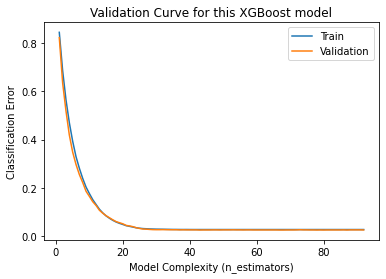

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

results = model.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Validation Curve for this XGBoost model')
plt.legend();